__Read usual modules__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys

In [3]:
sys.path.append('/home/nicolasf/python/')

In [4]:
from wavelet import *

In [5]:
import pandas as pd

In [8]:
data = pd.read_excel('./data/Average Annual SST Values and Anomalies in the Waters Around NZ from 1854-2018.xlsx')

In [9]:
data.head()

,DEPARTURE FROM NORMAL (1981-2010) IN ⁰C,Unnamed: 1,AVG SST (⁰C),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
1854,-0.943637,NaN,13.846794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855,-0.515418,NaN,14.275013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1856,-0.620602,NaN,14.169829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1857,-0.525248,NaN,14.265184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1858,-0.651091,NaN,14.139340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data = data.iloc[:,0]

In [11]:
data.head()

1854   -0.943637
1855   -0.515418
1856   -0.620602
1857   -0.525248
1858   -0.651091
Name: DEPARTURE FROM NORMAL (1981-2010) IN ⁰C, dtype: float64

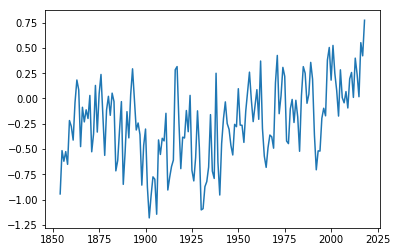

In [12]:
data.plot()

In [13]:
sst = data.values.flatten()

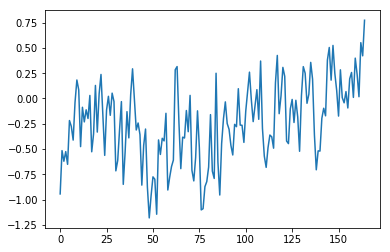

In [14]:
plt.plot(sst)

In [15]:
time = data.index.to_series().values

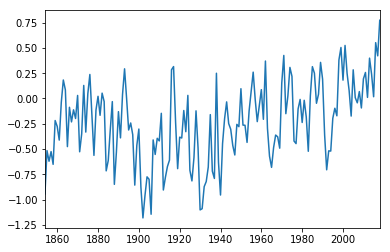

In [16]:
n=len(sst)
dt = 1 

xlim = [time.min(),time.max()]  # plotting range

plt.plot(time,sst)
xrange=plt.xlim(xlim)

------------------------------------------------------ Computation

 Normalize by standard deviation (not necessary, but makes it easier to compare with plot on Interactive Wavelet page, at
 "http://paos.colorado.edu/research/wavelets/plot/" )



# Wavelet Spectrum by Torrence and Compo [1998]

In [17]:
variance = np.std(sst)**2
mean=np.mean(sst)
sst = (sst - np.mean(sst))/np.sqrt(variance)
print("mean=",mean)
print("std=", np.sqrt(variance))

mean= -0.23826120802623238
std= 0.388365138419832


__Set wavelet parameters__

In [18]:
pad = 1      # pad the time series with zeroes (recommended)
dj = 0.25    # this will do 4 sub-octaves per octave
s0 = 2.*dt    # this says start at a scale of 6 months
j1 = 7./dj    # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'Morlet'

__Wavelet transform__

In [19]:
wave,period,scale,coi = wavelet(sst,dt,pad,dj,s0,j1,mother);
power = (np.abs(wave))**2         # compute wavelet power spectrum

__Significance levels:__   
(variance=1 for the normalized SST)

In [20]:
signif,fft_theor = wave_signif(1.0,dt,scale,0,lag1,-1,-1,mother)
sig95 = np.dot(signif.reshape(len(signif),1),np.ones((1,n))) # expand signif --> (J+1)x(N) array
sig95 = power / sig95         # where ratio > 1, power is significant

__Global wavelet spectrum & significance levels__

In [21]:
global_ws = variance*power.sum(axis=1)/float(n)   # time-average over all times
dof = n - scale  # the -scale corrects for padding at edges
global_signif,fft_theor = wave_signif(variance,dt,scale,1,lag1,-1,dof,mother)

__Scale-average between El Nino periods of 2--8 years__

In [22]:
avg = (scale >= 2) & (scale < 8)
Cdelta = 0.776;   # this is for the MORLET wavelet
scale_avg = np.dot(scale.reshape(len(scale),1),np.ones((1,n))) # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg   # [Eqn(24)]
scale_avg = variance*dj*dt/Cdelta*sum(scale_avg[avg,:])   # [Eqn(24)]
scaleavg_signif ,fft_theor= wave_signif(variance,dt,scale,2,lag1,-1,[2,7.9],mother)

__Reconstuction__

Define inverse wavelet function base on Torrence and Compo [1998], eq. (11)
See list at the bottom of this note

Reconstruct

In [23]:
iwave=wavelet_inverse(wave, scale, dt, dj, "Morlet")
print("root square mean error",np.sqrt(np.sum((sst-iwave)**2)/float(len(sst)))*np.sqrt(variance),"deg C")

root square mean error 0.029337600078171884 deg C


__Plot__

Corresponding to Fig. 4 top in Liu et al. (2007)

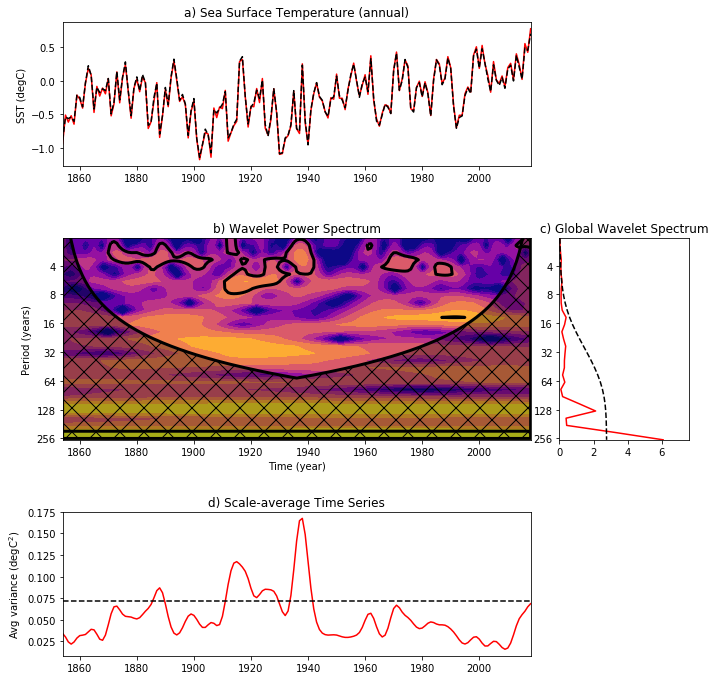

In [24]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.37, width, hight]
pos1c = [0.79, 0.37, 0.18, hight]
pos1d = [0.1,  0.07, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,sst*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('SST (degC)')
plt.title('a) Sea Surface Temperature (annual)')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contourf(time,np.log2(period),np.log2(power),np.log2(levels), extend='both', cmap='plasma')
bx.set_xlabel('Time (year)')
bx.set_ylabel('Period (years)')

import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],colors='k',linewidths=3)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',lw=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_ws,np.log2(period),"r-")
cx.plot(global_signif,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_ws)])

#########################################
#   d) Scale average Spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avg,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signif,scaleavg_signif],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance (degC$^2$)')
title=plt.title('d) Scale-average Time Series')
plt.savefig("nino3_TorrenceCompo.png")

# Wavelet Spectrum by Liu et al [2007]

<span style="color:red">__Bias rectification__  </span>
  
divided by scales  

In [25]:
########################
#  Spectrum
########################
powers=np.zeros_like(power)
for k in range(len(scale)):
    powers[k,:] = power[k,:]/scale[k]
#significance: sig95 is already normalized = 1

########################
#  Spectrum
########################
global_wss = global_ws/scale   
global_signifs=global_signif/scale

########################
#  Scale-average between El Nino periods of 2--8 years
########################
# No need to change 
# because in Eqn(24) of Torrence and Compo [1998], division by scale has been done.
scale_avgs=scale_avg
scaleavg_signifs=scaleavg_signif

__Plot__  

Corresponding to Fig. 4 bottom in Liu et al. (2007)

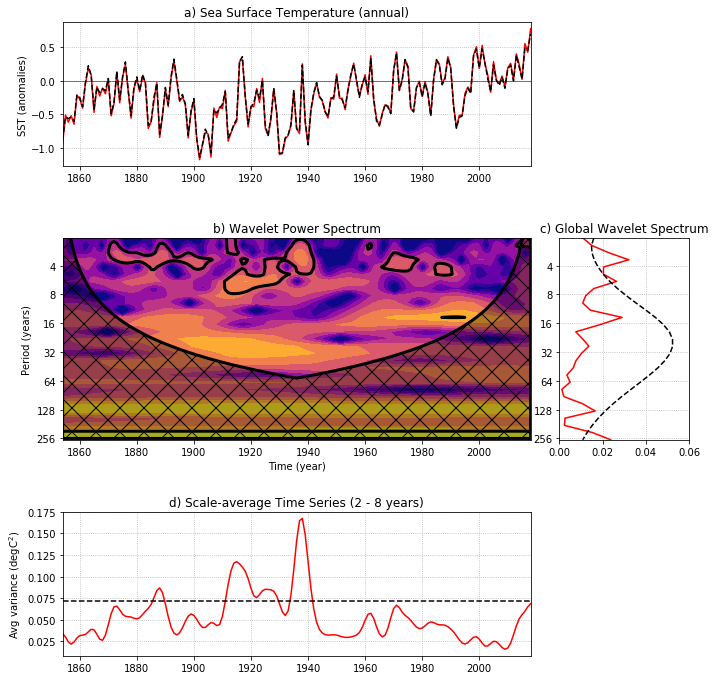

In [26]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.37, width, hight]
pos1c = [0.79, 0.37, 0.18, hight]
pos1d = [0.1,  0.07, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,sst*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")
ax.axhline(0, lw=0.5, color='k')
ax.grid(ls=':')
ax.set_ylabel('SST (anomalies)')
plt.title('a) Sea Surface Temperature (annual)')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contourf(time,np.log2(period),np.log2(power),np.log2(levels), extend='both', cmap='plasma')
bx.set_xlabel('Time (year)')
bx.set_ylabel('Period (years)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],colors='k',linewidths=3)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',lw=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_wss,np.log2(period),"r-")
cx.plot(global_signifs,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_wss)])
cx.set_xlim(0, 0.06)
cx.grid(ls=':')

#########################################
#   d) Global Wavelet spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avgs,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signifs,scaleavg_signifs],"k--")
dx.grid(ls=':')
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance (degC$^2$)')
title=plt.title('d) Scale-average Time Series (2 - 8 years)')
plt.savefig("../figures/SST_wavelets_analysis.png", dpi=200)